In [200]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

from pymongo import MongoClient
import collections
import matplotlib.pyplot as plt
import re
from random import choices
import string
nltk.download('popular', quiet = 'true')

True

In [201]:
# Mongodb information
client = MongoClient('localhost', 27017)
db = client['twitter']  
streaming_collection = db['streaming']
rest_collection = db['rest']
updated_geo = db['geo']

Get the total number of unique tweets taking away all the retweets and duplicated ids

In [202]:
rest_rt = list(rest_collection.find({"retweeted_status":{"$exists": False}}))
streaming_rt = list(streaming_collection.find({"retweeted_status":{"$exists": False}}))
combined_list = rest_rt + streaming_rt
distinct_list = list({tweet['id']:tweet for tweet in combined_list}.values())

Lemmatize all NOUNS only as clustering by events and verbs and everything else don't matter in that sense

In [203]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t, 'n') for t in word_tokenize(doc)]

Use countvectorizer with the lemma tokenizer to create a bag of words for comparison
Remove stopwords, ensure everything is in unicode and lowercase everything, additionally I've added that words in the corpus must at least appear in two tweets so that can be a comparison

In [204]:
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer() ,
                             stop_words = "english", 
                             strip_accents = 'unicode',
                             lowercase = True,
                             min_df = 2,)

Create a corpus and do text processing such as 
- removing links
- removing non-ascii (emoji)
- Removing digits
- Removing words that are less than 3 character long
- parse through NLTK to only extract nouns for comparison into the corpus

Then finally vectorize all nouns(events) into a bag of words

In [205]:
corpus = []
for tweets in distinct_list:
    text = tweets['text']
    text = re.sub(r"http\S+", "", text) # remove links
    text = "".join(filter(lambda x: x in string.printable, text)) #remove non ascii
    text = "".join([i for i in text if not i.isdigit()]) #remove digits
    text = re.sub(r'\b\w{1,3}\b', '', text) #remove characters less than 3
    tokenized = word_tokenize(text)
    text = " ".join([word for (word, pos) in nltk.pos_tag(tokenized) if pos.startswith('N')])
    corpus.append(text)
X = vectorizer.fit_transform(corpus)

Using kmeans to cluster, as we are unsure of how many clusters should be used, we kmeans the data set with cluster 1-20 and plot a graph using the inertia to determin the elbow

In [206]:
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    kmeans = KMeans(n_clusters=k, n_jobs = -1, n_init=25, random_state=0).fit(X)
    Sum_of_squared_distances.append(kmeans.inertia_)

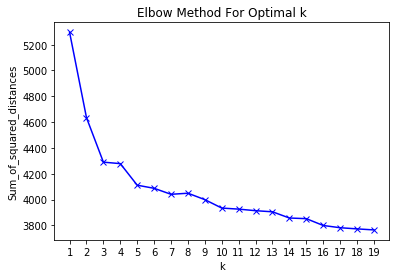

In [207]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xticks(K)
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

After determining the elbow, cluster based on that

In [261]:
kmeans = KMeans(n_clusters= 5,
                n_jobs = -1,
                n_init=25).fit(X)

In [239]:
labels = kmeans.labels_

Get the count of how many geo tagged tweets and how many profile have a location tagged to them
At the same time, I getting how many different locations there are in a cluster and the number of time the appear.
This is to do my probabilistic assignment of geo for every other tweet in the cluster

In [273]:
list_size = len(collections.Counter(labels))
geo_tagged = [0] * list_size
profile_location = [0] * list_size
tweet_per_cluster = [0] * list_size
cluster = [dict() for x in range(list_size)]
for i in range(len(corpus)):
    index = labels[i]
    if distinct_list[i]['place'] is not None:
        geo_tagged[index] +=1
        key =  distinct_list[i]['place']['full_name'] 
        if key in cluster[index]:
            cluster[index][key] +=1
        else:
            cluster[index][key] = 1
    if distinct_list[i]['user']['location'] is not None:
        profile_location[index] +=1
    tweet_per_cluster[index] += 1

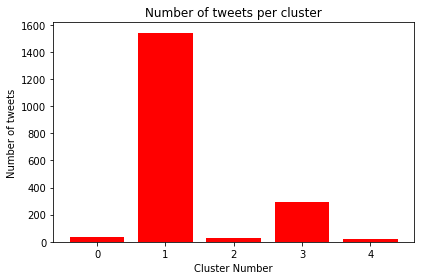

In [293]:
cluster_size = list(range(list_size))
plt.bar(cluster_size, tweet_per_cluster, color='r')
plt.title("Number of tweets per cluster")
plt.xlabel("Cluster Number")
plt.ylabel("Number of tweets")
plt.tight_layout()
plt.show()

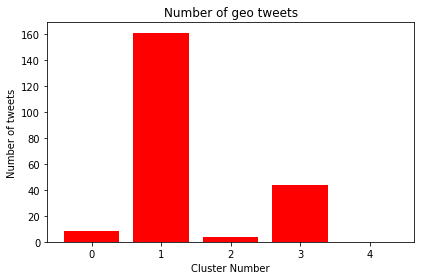

In [291]:
plt.bar(cluster_size, geo_tagged, color='r')
plt.title("Number of geo tweets")
plt.xlabel("Cluster Number")
plt.ylabel("Number of tweets")
plt.tight_layout()
plt.show()

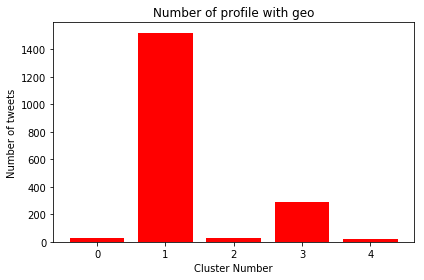

In [274]:
plt.bar(cluster_size, profile_location, color='r')
plt.title("Number of profile with geo")
plt.xlabel("Cluster Number")
plt.ylabel("Number of tweets")
plt.tight_layout()
plt.show()

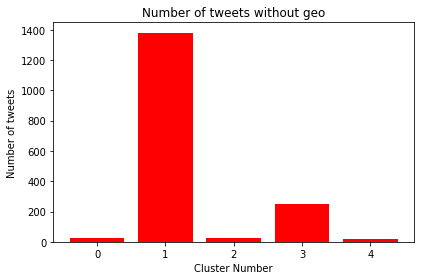

[32, 1541, 28, 291, 21]

In [301]:
no_geo = [0] * list_size
for i in range(0,list_size):
    no_geo[i] = tweet_per_cluster[i] - geo_tagged[i]
plt.bar(cluster_size, no_geo, color='r')
plt.title("Number of tweets without geo")
plt.xlabel("Cluster Number")
plt.ylabel("Number of tweets")
plt.tight_layout()
plt.show()
tweet_per_cluster

Function for getting the weights of each location in percentage in each cluster

In [211]:
def count_location_weights(cluster,list_size):
    location = []
    weights = []
    for i in range(0,list_size):
        for key in cluster[i]:
            cluster[i][key] = cluster[i][key]/geo_tagged[i] * 100
        location.append(list(cluster[i].keys()))
        weights.append(list(cluster[i].values()))
    return location, weights

In [212]:
location, weights = count_location_weights(cluster, list_size)

Assign all other tweets in each cluster without geo information using a probabilistic model and assign a new json field for storage

In [213]:
#assigning geo based on probabilistic model
for i in range(len(corpus)):
    index = labels[i]
    if distinct_list[i]['place'] is None:
        if location[index]:
            distinct_list[i]['assigned_geo'] = choices(location[index],weights[index])

Check the accuracy using the probabilitic model by using 50% of the geo tagged data as a training set and assigning the other 50% 

In [304]:
list_size = len(collections.Counter(labels))
geo_counter = [0] * list_size
training_cluster = [dict() for x in range(list_size)]
for i in range(len(corpus)):
    index = labels[i]
    if distinct_list[i]['place'] is not None:
        if int(geo_tagged[index]/2) != geo_counter[index]:
            geo_counter[index] += 1
            key =  distinct_list[i]['place']['full_name']
            distinct_list[i]["training"] = True
            if key in training_cluster[index]:
                training_cluster[index][key] +=1
            else:
                training_cluster[index][key] = 1
        else:
            distinct_list[i]["training"] = False

training_location, training_weights = count_location_weights(training_cluster, list_size) 

Assign the 50% with the train probabilitic model and assign accordingly, if there is no geo tagged data or only 1, assignment is not possible

In [307]:
percentage = [0]* list_size 
for i in range(len(corpus)):
    index = labels[i]
    if distinct_list[i]['place'] is not None and distinct_list[i]["training"] is False and geo_tagged[index] > 1:
        assigned = choices(training_location[index],training_weights[index])[0]
        if assigned == distinct_list[i]['place']['full_name']:
            percentage[index] += 1
            
for i in range(len(percentage)):
    if geo_tagged[i] < 2:
        print(f"No assignment possible due either 0 or 1 geo tweets for cluster {i}")
    elif (percentage[i]/(geo_tagged[i]/2)) > 1:
        print(f"Acuracy using 50% as training data and 50% as assignment for cluster {i}: 100%")
    else:
        print(f"Acuracy using 50% as training data and 50% as assignment for cluster {i}: {percentage[i]/(geo_tagged[i]/2) * 100}%")

Acuracy using 50% as training data and 50% as assignment for cluster 0: 50.0%
Acuracy using 50% as training data and 50% as assignment for cluster 1: 33.54037267080746%
Acuracy using 50% as training data and 50% as assignment for cluster 2: 50.0%
Acuracy using 50% as training data and 50% as assignment for cluster 3: 40.909090909090914%
No assignment possible due either 0 or 1 geo tweets for cluster 4
